# Flag Predictor - All Locations Visualization

This notebook processes **all locations** (Isis, Godstow, and Wallingford) in a loop.
Each location is processed completely with its own visualizations.

**Note:** Rainfall data is loaded location-specifically (only the stations needed for each location):
- **ISIS**: 13 default stations
- **Godstow**: 11 stations (excludes Bicester and Grimsbury)
- **Wallingford**: 19 stations (all default + 6 Wallingford-specific stations)

In [1]:
# Standard imports
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from tqdm import tqdm
import importlib

# Add src to path for development
sys.path.insert(0, os.path.abspath('../src'))

# Force reload of flag_predictor modules (in case they were modified)
import flag_predictor
import flag_predictor.data.api
import flag_predictor.config
importlib.reload(flag_predictor.data.api)
importlib.reload(flag_predictor.config)
importlib.reload(flag_predictor)

# Flag Predictor imports
from flag_predictor import get_location_config
from flag_predictor.pipeline import prepare_training_data
from flag_predictor.models import load_model
from flag_predictor.prediction import predict_ensemble
from flag_predictor.data.api import get_rainfall_forecast_ensemble
from flag_predictor.config import (
    LOCATIONS,
    RAINFALL_STATION_NAMES, 
    WALLINGFORD_RAINFALL_STATION_NAMES,
    FLAG_COLORS,
    get_flag_thresholds
)

def get_location_station_names(location: str) -> list:
    """
    Get the correct rainfall station names for a given location.
    
    - ISIS: All default stations (13 stations)
    - Godstow: Default stations EXCEPT Bicester and Grimsbury (11 stations)
    - Wallingford: All default stations PLUS Wallingford-specific stations (19 stations)
    """
    location_lower = location.lower()
    
    if location_lower == 'wallingford':
        return list(RAINFALL_STATION_NAMES) + list(WALLINGFORD_RAINFALL_STATION_NAMES)
    elif location_lower == 'godstow':
        return [s for s in RAINFALL_STATION_NAMES if s not in {'Bicester', 'Grimsbury'}]
    else:
        return list(RAINFALL_STATION_NAMES)

def calculate_flag_probabilities(ensemble_df, thresholds):
    """Calculate probability of each flag color at each timestep."""
    n_members = ensemble_df.shape[1]
    probs_df = pd.DataFrame(index=ensemble_df.index)
    
    for flag, (lower, upper) in thresholds.items():
        count = ((ensemble_df >= lower) & (ensemble_df < upper)).sum(axis=1)
        probs_df[f'p_{flag}'] = count / n_members
    
    return probs_df

def get_flag_from_diff(diff, thresholds):
    """Get flag color from differential value."""
    if diff >= thresholds['red'][0]:
        return 'RED'
    elif diff >= thresholds['amber'][0]:
        return 'AMBER'
    elif diff >= thresholds['dark_blue'][0]:
        return 'DARK BLUE'
    elif diff >= thresholds['light_blue'][0]:
        return 'LIGHT BLUE'
    else:
        return 'GREEN'

# Plot settings
plt.rcParams['figure.figsize'] = (18, 10)
plt.rcParams['font.size'] = 11

print("✓ Imports complete")

✓ Imports complete


## Process All Locations

This cell processes each location in a loop, loading only the rainfall data needed for each location.

Processing all locations: ['isis', 'godstow', 'wallingford']
Total locations: 3

PROCESSING LOCATION: ISIS

Location: Isis Stretch
Horizons: 24 prediction points
Max horizon: 240 hours (10 days)

Flag thresholds for isis:
  green: -inf - 0.215
  light_blue: 0.215 - 0.330
  dark_blue: 0.330 - 0.440
  amber: 0.440 - 0.535
  red: 0.535 - inf

STEP 1: Preparing historical data for ISIS

Preparing training data for Isis Stretch
✓ Loaded Isis Stretch historical data: (216385, 1)
  Date range: 2017-02-04 12:00:00+00:00 to 2026-01-20 10:15:00+00:00
Filtering out Wallingford-specific stations for isis...
Loading historical rainfall data from 19 files...

✓ Combined historical rainfall: (314534, 19)
  Date range: 2017-02-02 00:00:00 to 2026-01-22 09:00:00
Fetching river level data...
  ✓ kings_mill_downstream: 2818 records
  ✓ godstow_downstream: 2818 records
  ✓ osney_upstream: 2818 records
  ✓ osney_downstream: 2817 records
  ✓ iffley_upstream: 2816 records
  ✓ benson_downstream: 2818 records


/Users/robertds413/Documents/Flag_Predictor/src/flag_predictor/processing/features.py:256: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'differential_velocity_{i}h'] = df[differential_column].diff(periods=i) / i
/Users/robertds413/Documents/Flag_Predictor/src/flag_predictor/processing/features.py:261: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'differential_acceleration_{i}h'] = velocity.diff(periods=i) / i
/Users/robertds413/Documents/Flag_Predictor/src/flag_predictor/processing/features.py:261: PerformanceWarning: 

Creating targets for 24 horizons...

Multi-Horizon Model Setup:
Number of features: 125
Number of horizons: 24
Horizons: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 30, 36, 42, 48, 72, 96, 120, 144, 168, 192, 216, 240]
Training samples: 67263
Date range: 2017-02-04 12:00:00+00:00 to 2026-01-18 07:00:00+00:00

✓ Dropping 719 rows with NaNs in features/targets (after feature engineering)

STEP 2: Loading model for ISIS
Using device: mps (Apple Silicon GPU)


/Users/robertds413/Documents/Flag_Predictor/.venv_new/lib/python3.12/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


✓ Model loaded from: ../models/multihorizon_model_experiment_2026_01_isis.pth
✓ Scaler loaded from: ../models/scaler_experiment_2026_01_isis.pkl
✓ Sequence length: 120
✓ Horizons: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 30, 36, 42, 48, 72, 96, 120, 144, 168, 192, 216, 240]

Model configuration:
  Sequence length: 120
  Hidden sizes: [192, 128, 64]
  Features: 111

STEP 3: Fetching location-specific rainfall forecast for ISIS
Note: Only loading stations needed for isis (optimized)
✓ Successfully fetched ensemble forecast: 13 stations × 50 members

✓ Rainfall forecast: (240, 650)
  Time range: 2026-01-28 00:00:00 to 2026-02-06 23:00:00
  Stations loaded: 13

STEP 4: Running ensemble prediction for ISIS
ENSEMBLE PREDICTION
Using 50 ensemble members
Stations: 13
Forecast horizons: 24 points


Processing ensemble members:   0%|          | 0/50 [00:00<?, ?it/s]/Users/robertds413/Documents/Flag_Predictor/src/flag_predictor/processing/features.py:256: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'differential_velocity_{i}h'] = df[differential_column].diff(periods=i) / i
/Users/robertds413/Documents/Flag_Predictor/src/flag_predictor/processing/features.py:261: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'differential_acceleration_{i}h'] = velocity.diff(periods=i) / i
/Users/robertds413/Documents/Flag_Predictor/


✓ Generated 50 ensemble predictions
  Forecast shape: (241, 50)
  Time range: 2026-01-28 07:00:00+00:00 to 2026-02-07 07:00:00+00:00

STEP 5: Generating visualizations for ISIS

STEP 7: Spaghetti Plot - All Ensemble Members with Rainfall
Preparing rainfall data...
  Historical rainfall: 9 daily bars (avg across stations)
  Forecast rainfall: 10 daily bars with ensemble spread (P10-P90)
Plotting 50 ensemble member trajectories...


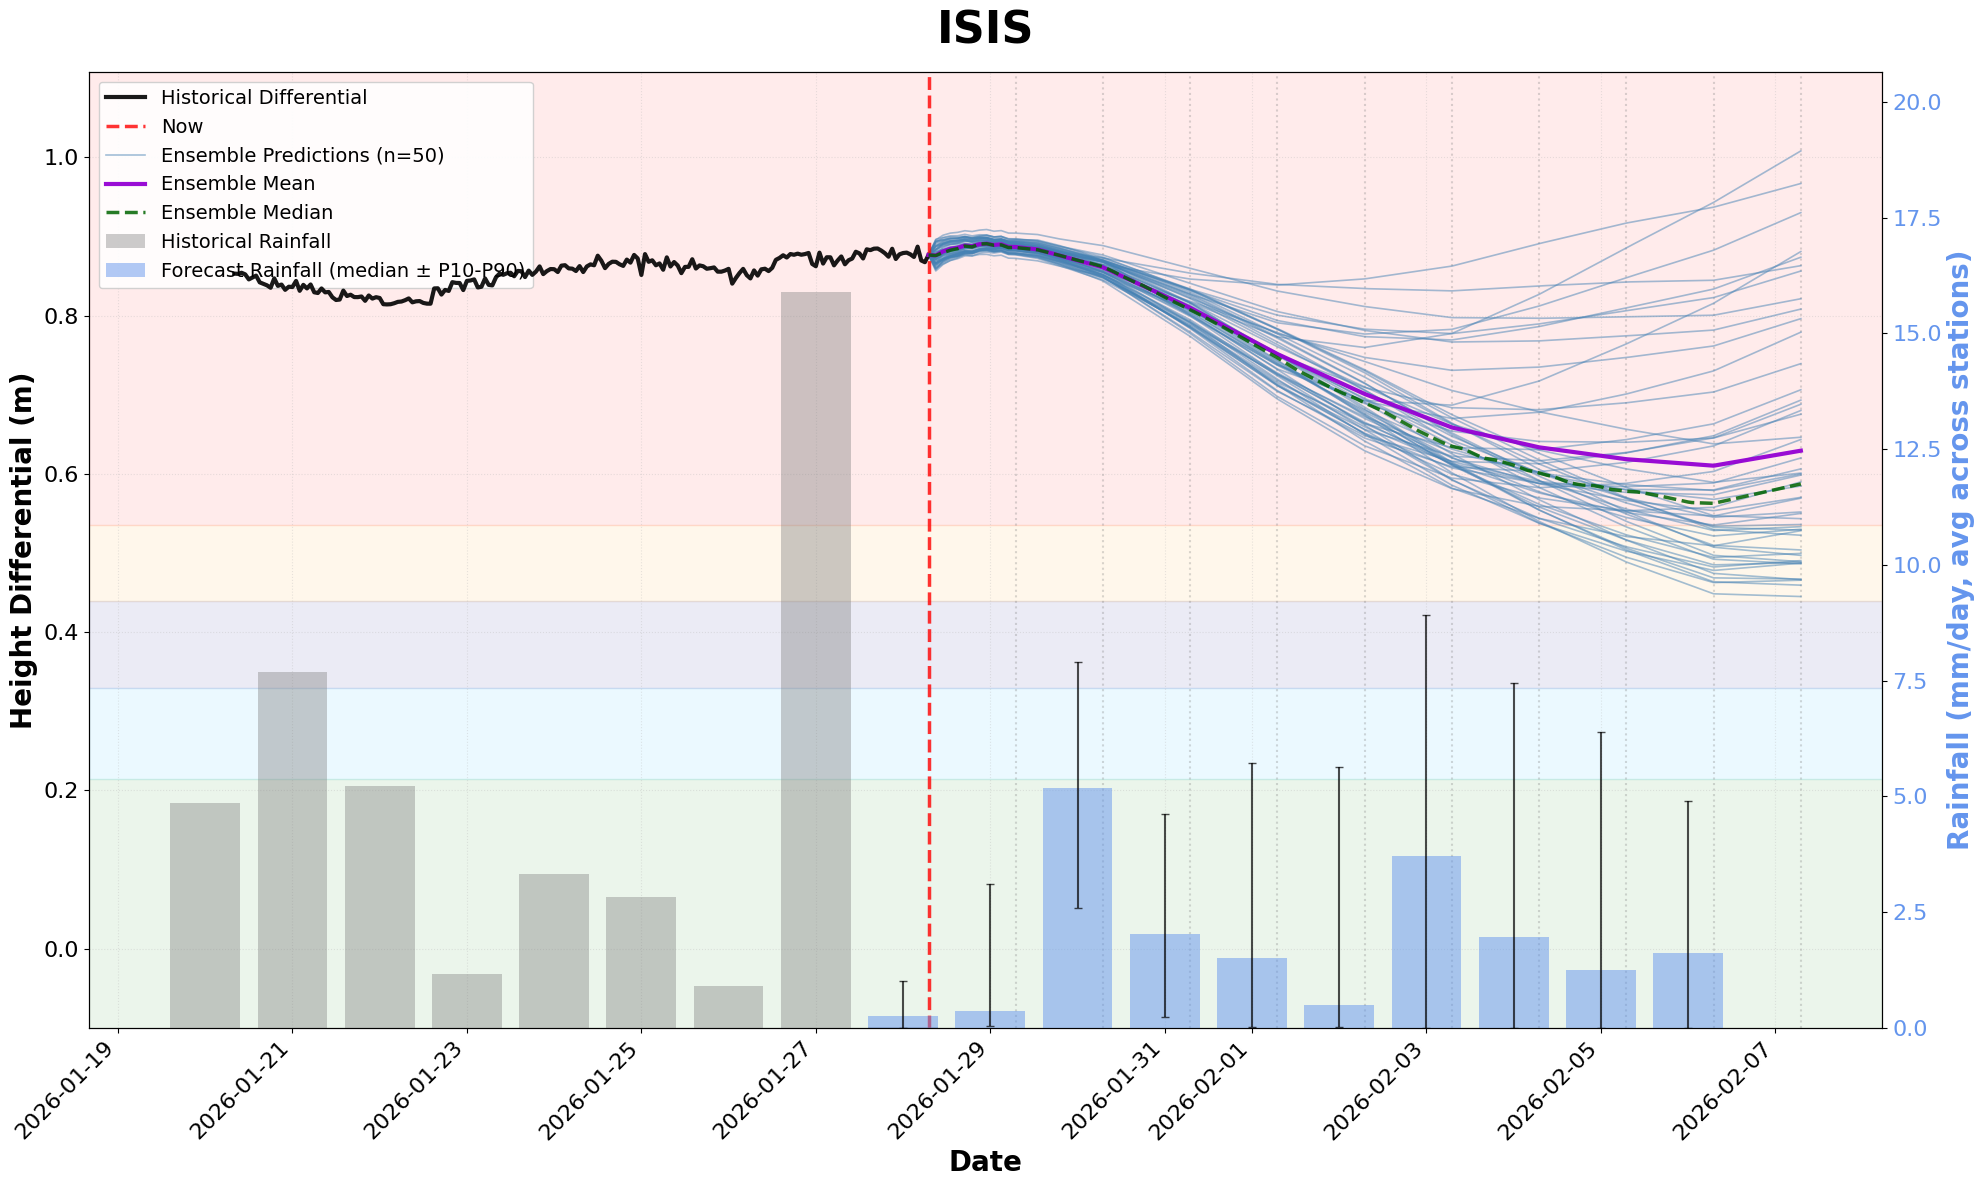


✓ Spaghetti plot with rainfall complete!
  River: 50 ensemble forecasts (blue lines) + mean (purple) + median (green dashed)
  Rainfall: Historical (gray bars) + Forecast with P10-P90 error bars (blue bars)

✓ Flag probabilities calculated for 241 timesteps

FLAG PROBABILITIES AT KEY HORIZONS
Hour        Green    Lt Blue    Dk Blue    Amber      Red
----------------------------------------------------------------------
0            0.0%       0.0%       0.0%     0.0%   100.0%
6            0.0%       0.0%       0.0%     0.0%   100.0%
12           0.0%       0.0%       0.0%     0.0%   100.0%
24           0.0%       0.0%       0.0%     0.0%   100.0%
48           0.0%       0.0%       0.0%     0.0%   100.0%
72           0.0%       0.0%       0.0%     0.0%   100.0%
120          0.0%       0.0%       0.0%     0.0%   100.0%
168          0.0%       0.0%       0.0%     0.0%   100.0%
240          0.0%       0.0%       0.0%    36.0%    64.0%


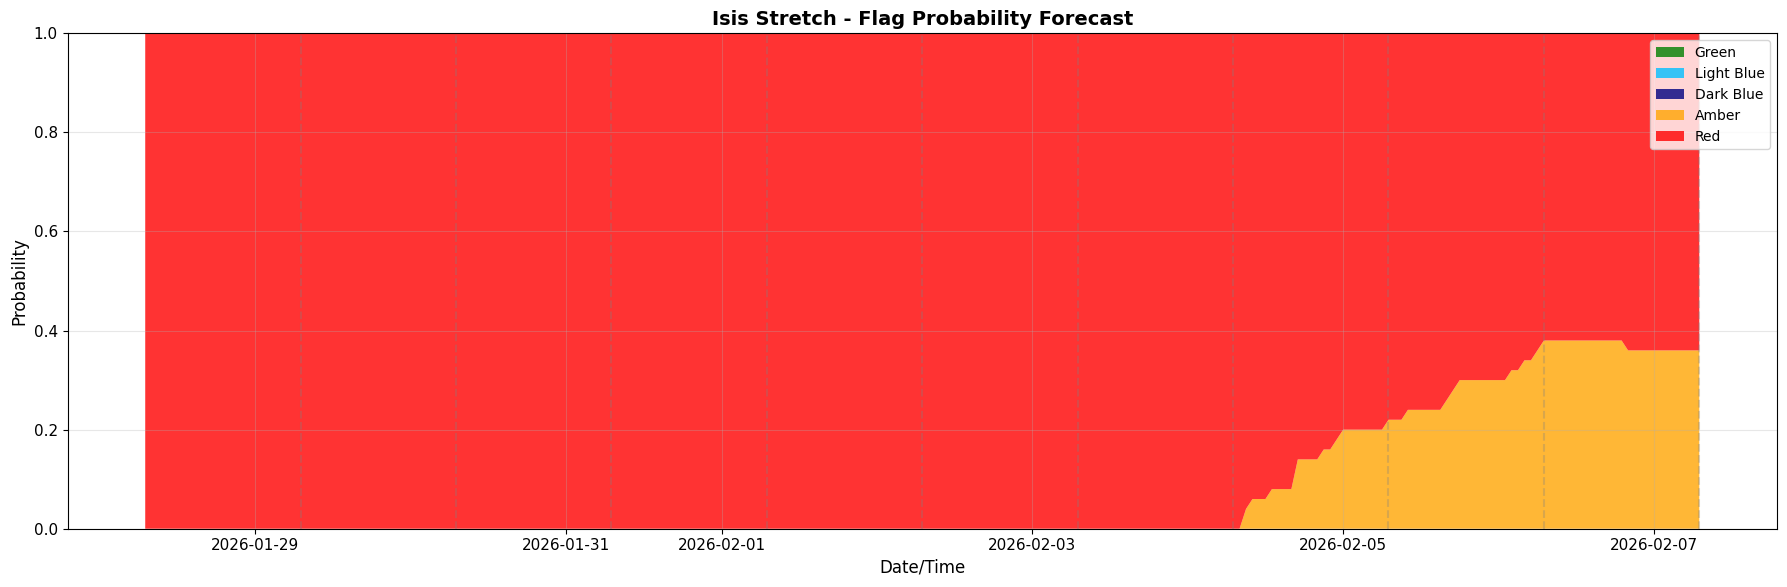


✓ Plot saved as 'flag_probabilities_isis.png'

FORECAST SUMMARY - Isis Stretch

Current differential: 0.877m (RED flag)

Forecast at key horizons:
   Horizon       Mean        Range (5-95%)   Most likely flag
----------------------------------------------------------------------
     24h       0.887m    0.877m - 0.896m                   RED
     48h       0.861m    0.848m - 0.874m                   RED
     72h       0.810m    0.781m - 0.844m                   RED
    120h       0.701m    0.643m - 0.799m                   RED
    168h       0.634m    0.542m - 0.820m                   RED
    240h       0.629m    0.466m - 0.908m                   RED

✓ Completed processing for ISIS


PROCESSING LOCATION: GODSTOW

Location: Godstow Stretch
Horizons: 24 prediction points
Max horizon: 240 hours (10 days)

Flag thresholds for godstow:
  green: -inf - 0.450
  light_blue: 0.450 - 0.450
  dark_blue: 0.450 - 0.450
  amber: 0.450 - 0.750
  red: 0.750 - inf

STEP 1: Preparing historical data fo

/Users/robertds413/Documents/Flag_Predictor/src/flag_predictor/processing/features.py:261: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'differential_acceleration_{i}h'] = velocity.diff(periods=i) / i
/Users/robertds413/Documents/Flag_Predictor/src/flag_predictor/processing/features.py:261: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'differential_acceleration_{i}h'] = velocity.diff(periods=i) / i
/Users/robertds413/Documents/Flag_Predictor/src/flag_predictor/processing/features.py:261: PerformanceWarning: DataFrame i

Creating targets for 24 horizons...

Multi-Horizon Model Setup:
Number of features: 123
Number of horizons: 24
Horizons: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 30, 36, 42, 48, 72, 96, 120, 144, 168, 192, 216, 240]
Training samples: 64410
Date range: 2017-02-02 01:00:00+00:00 to 2026-01-18 08:00:00+00:00

✓ Dropping 719 rows with NaNs in features/targets (after feature engineering)

STEP 2: Loading model for GODSTOW
Using device: mps (Apple Silicon GPU)
✓ Model loaded from: ../models/multihorizon_model_experiment_2026_01_godstow.pth
✓ Scaler loaded from: ../models/scaler_experiment_2026_01_godstow.pkl
✓ Sequence length: 100
✓ Horizons: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 30, 36, 42, 48, 72, 96, 120, 144, 168, 192, 216, 240]

Model configuration:
  Sequence length: 100
  Hidden sizes: [192, 128, 64]
  Features: 117

STEP 3: Fetching location-specific rainfall forecast for GODSTOW
Note: Only loading stations needed for godstow (optimized)
✓ Successfully fetched ensemble for

Processing ensemble members:   0%|          | 0/50 [00:00<?, ?it/s]/Users/robertds413/Documents/Flag_Predictor/src/flag_predictor/processing/features.py:261: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'differential_acceleration_{i}h'] = velocity.diff(periods=i) / i
/Users/robertds413/Documents/Flag_Predictor/src/flag_predictor/processing/features.py:261: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'differential_acceleration_{i}h'] = velocity.diff(periods=i) / i
/Users/robertds413/Documents/Flag_Predictor/src/flag_pr


✓ Generated 50 ensemble predictions
  Forecast shape: (241, 50)
  Time range: 2026-01-28 08:00:00+00:00 to 2026-02-07 08:00:00+00:00

STEP 5: Generating visualizations for GODSTOW

STEP 7: Spaghetti Plot - All Ensemble Members with Rainfall
Preparing rainfall data...
  Historical rainfall: 9 daily bars (avg across stations)
  Forecast rainfall: 10 daily bars with ensemble spread (P10-P90)
Plotting 50 ensemble member trajectories...


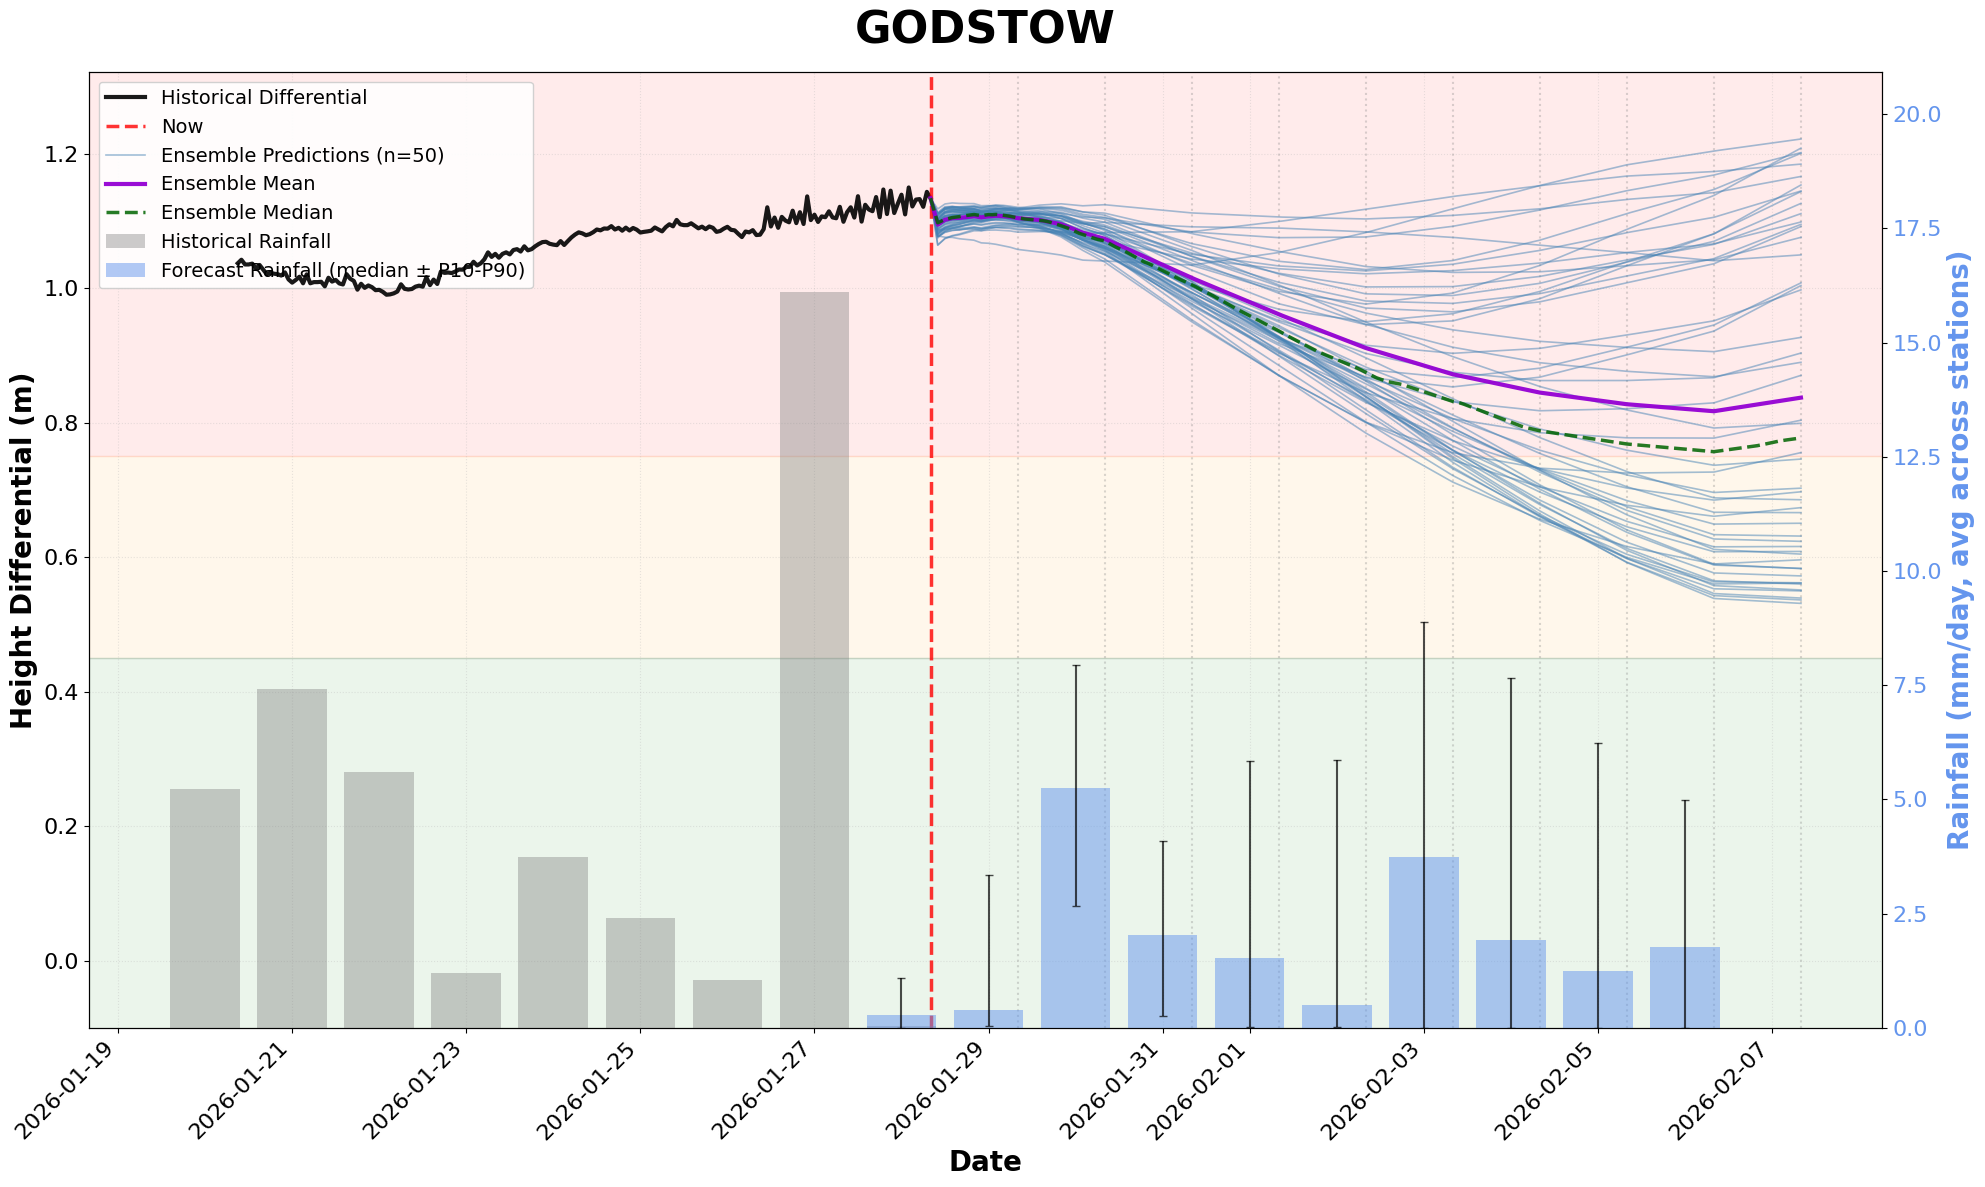


✓ Spaghetti plot with rainfall complete!
  River: 50 ensemble forecasts (blue lines) + mean (purple) + median (green dashed)
  Rainfall: Historical (gray bars) + Forecast with P10-P90 error bars (blue bars)

✓ Flag probabilities calculated for 241 timesteps

FLAG PROBABILITIES AT KEY HORIZONS
Hour        Green    Lt Blue    Dk Blue    Amber      Red
----------------------------------------------------------------------
0            0.0%       0.0%       0.0%     0.0%   100.0%
6            0.0%       0.0%       0.0%     0.0%   100.0%
12           0.0%       0.0%       0.0%     0.0%   100.0%
24           0.0%       0.0%       0.0%     0.0%   100.0%
48           0.0%       0.0%       0.0%     0.0%   100.0%
72           0.0%       0.0%       0.0%     0.0%   100.0%
120          0.0%       0.0%       0.0%     0.0%   100.0%
168          0.0%       0.0%       0.0%    42.0%    58.0%
240          0.0%       0.0%       0.0%    48.0%    52.0%


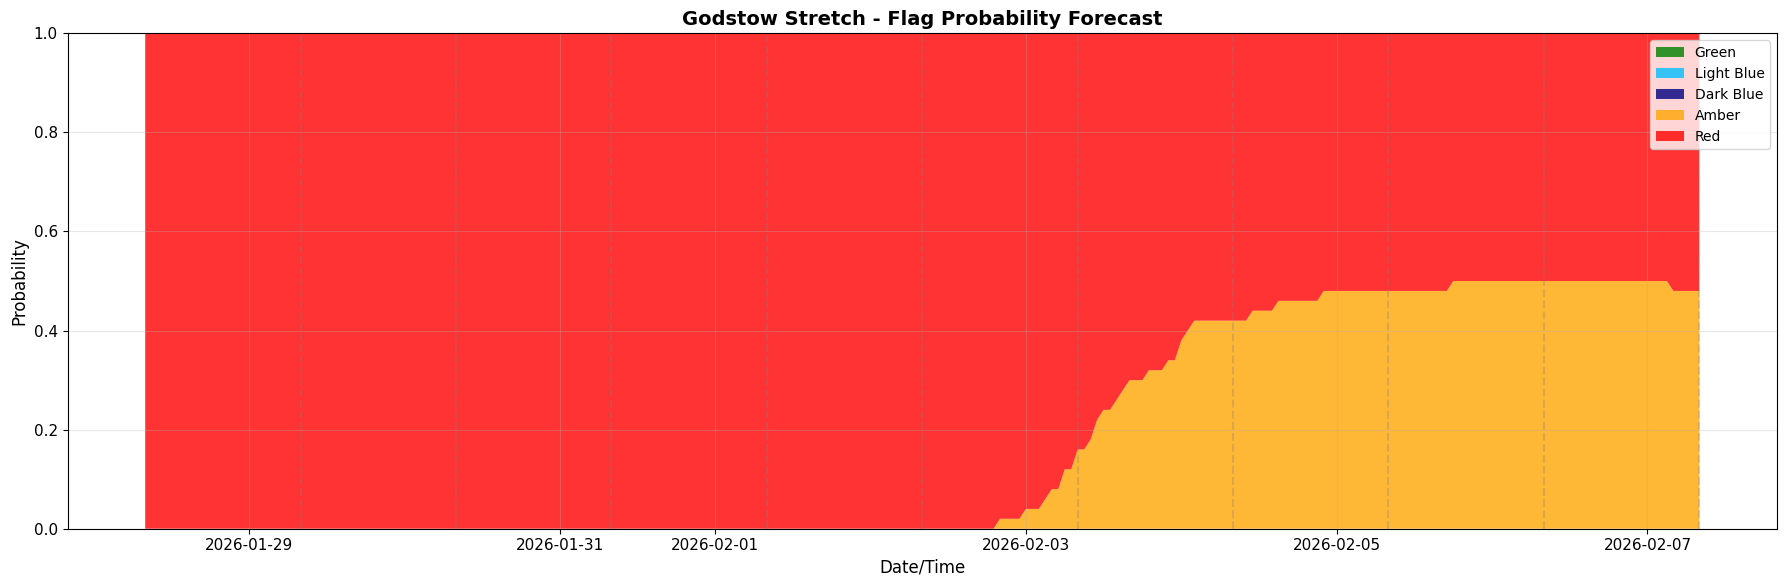


✓ Plot saved as 'flag_probabilities_godstow.png'

FORECAST SUMMARY - Godstow Stretch

Current differential: 1.134m (RED flag)

Forecast at key horizons:
   Horizon       Mean        Range (5-95%)   Most likely flag
----------------------------------------------------------------------
     24h       1.104m    1.088m - 1.119m                   RED
     48h       1.074m    1.047m - 1.107m                   RED
     72h       1.015m    0.966m - 1.084m                   RED
    120h       0.911m    0.801m - 1.084m                   RED
    168h       0.845m    0.661m - 1.117m                   RED
    240h       0.837m    0.544m - 1.201m                   RED

✓ Completed processing for GODSTOW


PROCESSING LOCATION: WALLINGFORD

Location: Wallingford Stretch
Horizons: 24 prediction points
Max horizon: 240 hours (10 days)

Flag thresholds for wallingford: Not displayed (white flags - no flags)

STEP 1: Preparing historical data for WALLINGFORD

Preparing training data for Wallingford Stre

/Users/robertds413/Documents/Flag_Predictor/src/flag_predictor/processing/features.py:256: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'differential_velocity_{i}h'] = df[differential_column].diff(periods=i) / i
/Users/robertds413/Documents/Flag_Predictor/src/flag_predictor/processing/features.py:261: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'differential_acceleration_{i}h'] = velocity.diff(periods=i) / i
/Users/robertds413/Documents/Flag_Predictor/src/flag_predictor/processing/features.py:261: PerformanceWarning: 

Creating targets for 24 horizons...

Multi-Horizon Model Setup:
Number of features: 125
Number of horizons: 24
Horizons: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 30, 36, 42, 48, 72, 96, 120, 144, 168, 192, 216, 240]
Training samples: 50114
Date range: 2020-02-13 20:00:00+00:00 to 2026-01-18 08:00:00+00:00

✓ Dropping 719 rows with NaNs in features/targets (after feature engineering)

STEP 2: Loading model for WALLINGFORD
Using device: mps (Apple Silicon GPU)
✓ Model loaded from: ../models/multihorizon_model_experiment_2026_01_wallingford.pth
✓ Scaler loaded from: ../models/scaler_experiment_2026_01_wallingford.pkl
✓ Sequence length: 100
✓ Horizons: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 30, 36, 42, 48, 72, 96, 120, 144, 168, 192, 216, 240]

Model configuration:
  Sequence length: 100
  Hidden sizes: [192, 128, 64]
  Features: 125

STEP 3: Fetching location-specific rainfall forecast for WALLINGFORD
Note: Only loading stations needed for wallingford (optimized)
✓ Successfully 

Processing ensemble members:   0%|          | 0/50 [00:00<?, ?it/s]/Users/robertds413/Documents/Flag_Predictor/src/flag_predictor/processing/features.py:256: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'differential_velocity_{i}h'] = df[differential_column].diff(periods=i) / i
/Users/robertds413/Documents/Flag_Predictor/src/flag_predictor/processing/features.py:261: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'differential_acceleration_{i}h'] = velocity.diff(periods=i) / i
/Users/robertds413/Documents/Flag_Predictor/


✓ Generated 50 ensemble predictions
  Forecast shape: (241, 50)
  Time range: 2026-01-28 08:00:00+00:00 to 2026-02-07 08:00:00+00:00

STEP 5: Generating visualizations for WALLINGFORD

STEP 7: Spaghetti Plot - All Ensemble Members with Rainfall
Preparing rainfall data...
  Historical rainfall: 9 daily bars (avg across stations)
  Forecast rainfall: 10 daily bars with ensemble spread (P10-P90)
Plotting 50 ensemble member trajectories...


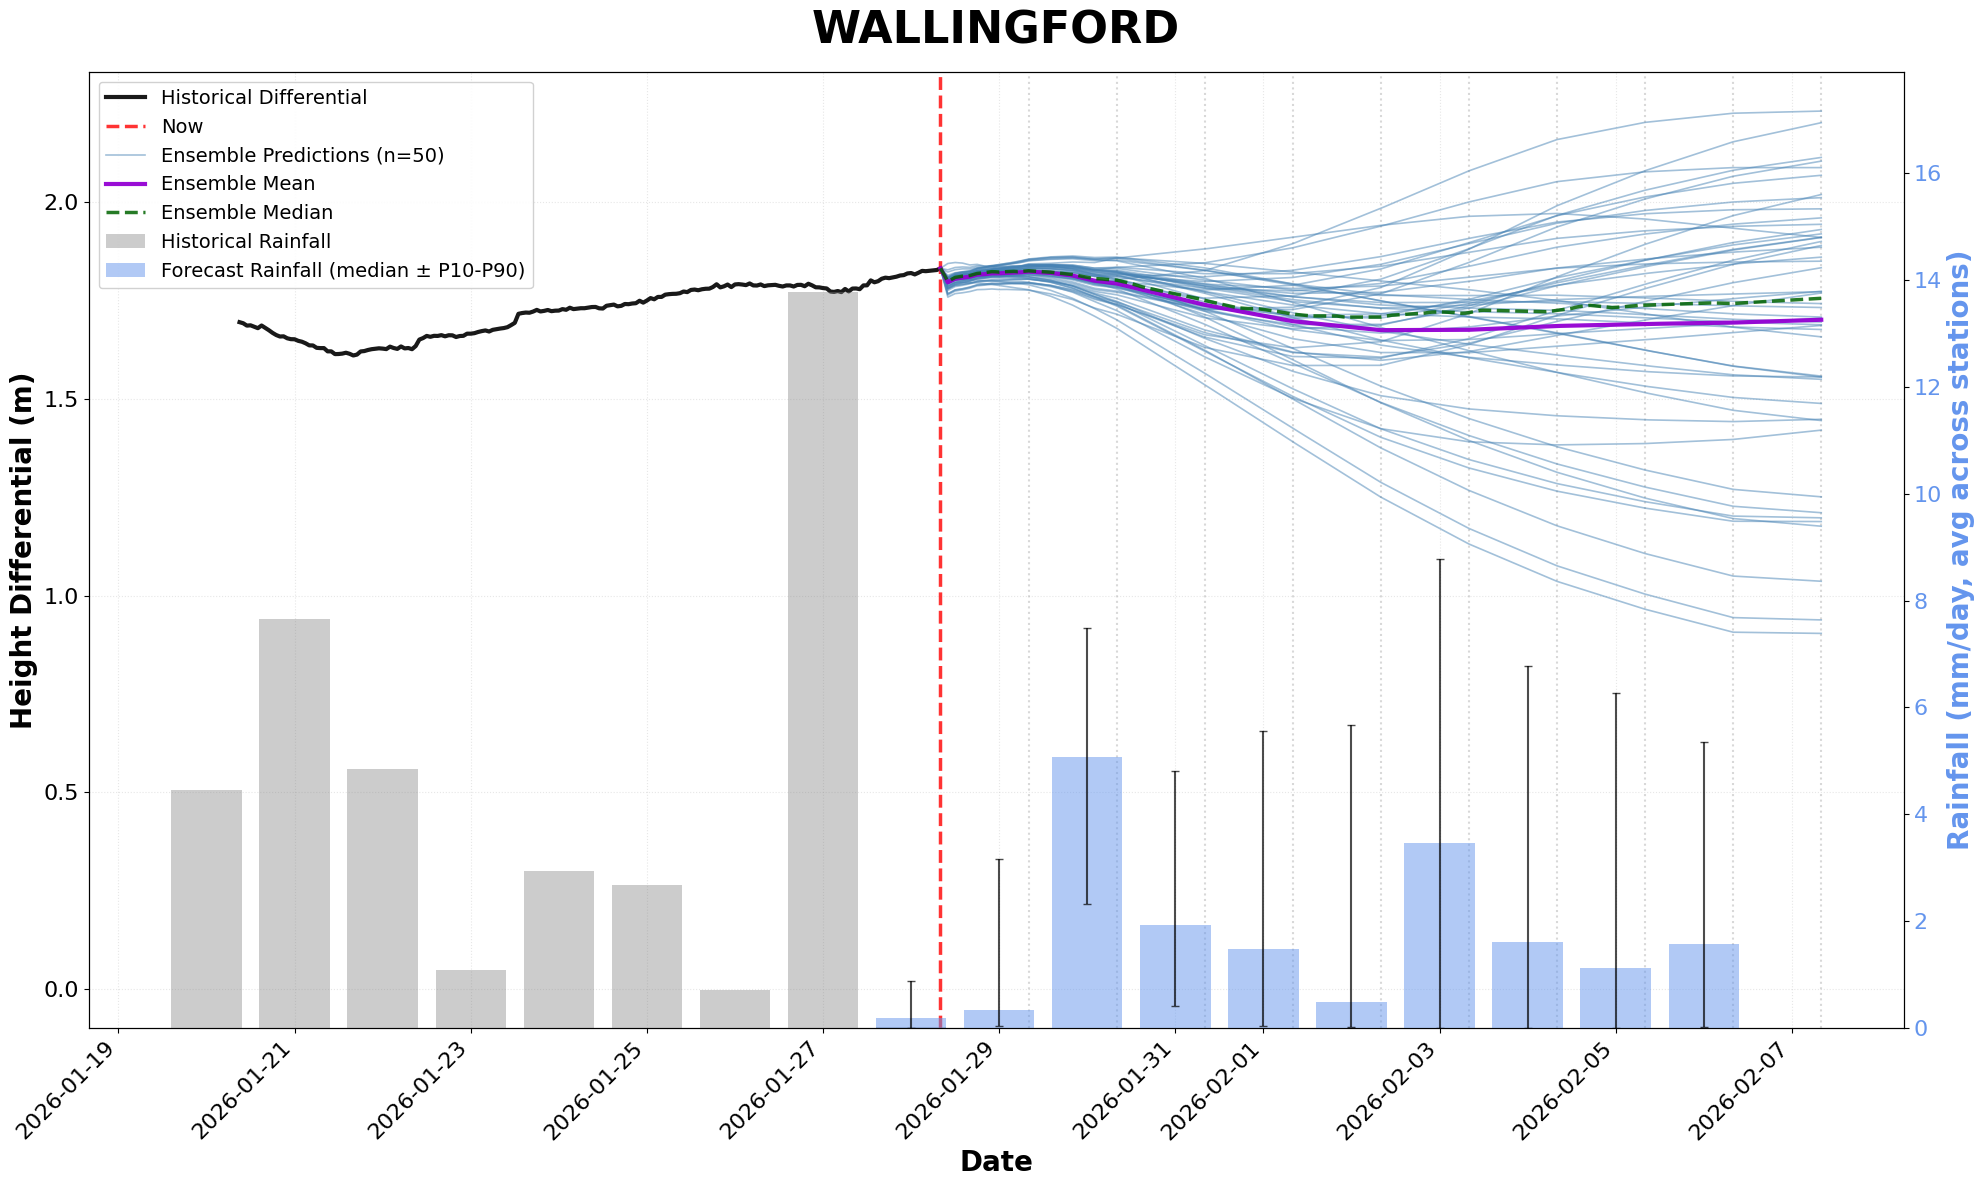


✓ Spaghetti plot with rainfall complete!
  River: 50 ensemble forecasts (blue lines) + mean (purple) + median (green dashed)
  Rainfall: Historical (gray bars) + Forecast with P10-P90 error bars (blue bars)

✓ Skipping flag probabilities for Wallingford (white flags - no flags)

FORECAST SUMMARY - Wallingford Stretch

Current differential: 1.833m (white flag - no flag)

Forecast at key horizons:
   Horizon       Mean        Range (5-95%)
----------------------------------------------------------------------
     24h       1.824m    1.792m - 1.854m
     48h       1.794m    1.720m - 1.858m
     72h       1.740m    1.614m - 1.840m
    120h       1.675m    1.388m - 1.905m
    168h       1.686m    1.217m - 1.983m
    240h       1.702m    1.099m - 2.110m

✓ Completed processing for WALLINGFORD



In [2]:
# Process all locations
LOCATIONS_TO_PROCESS = list(LOCATIONS.keys())
print(f"Processing all locations: {LOCATIONS_TO_PROCESS}")
print(f"Total locations: {len(LOCATIONS_TO_PROCESS)}")

# Model configuration
USE_EXPERIMENT_MODEL = True



# Process each location
for LOCATION in LOCATIONS_TO_PROCESS:
    print(f"\n{'='*80}")
    print(f"PROCESSING LOCATION: {LOCATION.upper()}")
    print(f"{'='*80}")
    
    # Get location config
    config = get_location_config(LOCATION)
    FLAG_THRESHOLDS = get_flag_thresholds(LOCATION)
    
    print(f"\nLocation: {config.display_name}")
    print(f"Horizons: {len(config.horizons)} prediction points")
    print(f"Max horizon: {max(config.horizons)} hours ({max(config.horizons)//24} days)")
    
    # Skip displaying thresholds for Wallingford (sensitive information)
    if LOCATION.lower() != 'wallingford':
        print(f"\nFlag thresholds for {LOCATION}:")
        for flag, (lower, upper) in FLAG_THRESHOLDS.items():
            print(f"  {flag}: {lower:.3f} - {upper:.3f}")
    else:
        print(f"\nFlag thresholds for {LOCATION}: Not displayed (white flags - no flags)")
    
    # ===== STEP 1: Prepare historical data =====
    print(f"\n{'='*70}")
    print(f"STEP 1: Preparing historical data for {LOCATION.upper()}")
    print(f"{'='*70}")

    merged_df, X, y_multi = prepare_training_data(
        location=LOCATION,
        project_root=os.path.abspath('..'),
        verbose=True
    )


    # ===== STEP 2: Load model =====
    print(f"\n{'='*70}")
    print(f"STEP 2: Loading model for {LOCATION.upper()}")
    print(f"{'='*70}")
    
    if USE_EXPERIMENT_MODEL:
        model, scaler, model_config = load_model(
            model_path=f"../models/multihorizon_model_experiment_2026_01_{LOCATION}.pth",
            scaler_path=f"../models/scaler_experiment_2026_01_{LOCATION}.pkl",
            config_path=f"../models/config_experiment_2026_01_{LOCATION}.pkl",
        )
    else:
        model, scaler, model_config = load_model(
            models_dir="../models",
            location=LOCATION,
        )
    
    print(f"\nModel configuration:")
    print(f"  Sequence length: {model_config['sequence_length']}")
    print(f"  Hidden sizes: {model_config['hidden_sizes']}")
    print(f"  Features: {len(model_config['feature_columns'])}")
    
    # ===== STEP 3: Fetch rainfall forecast (LOCATION-SPECIFIC - only loads needed stations) =====
    print(f"\n{'='*70}")
    print(f"STEP 3: Fetching location-specific rainfall forecast for {LOCATION.upper()}")
    print(f"{'='*70}")
    print(f"Note: Only loading stations needed for {LOCATION} (optimized)")
    
    rainfall_forecast = get_rainfall_forecast_ensemble(
        location=LOCATION,  # This ensures only location-specific stations are loaded
        ensemble_model='ecmwf_ifs025',
        n_members=50,
        forecast_days=10
    )
    
    print(f"\n✓ Rainfall forecast: {rainfall_forecast.shape}")
    print(f"  Time range: {rainfall_forecast.index[0]} to {rainfall_forecast.index[-1]}")
    print(f"  Stations loaded: {len(get_location_station_names(LOCATION))}")
    
    # ===== STEP 4: Run ensemble prediction =====
    print(f"\n{'='*70}")
    print(f"STEP 4: Running ensemble prediction for {LOCATION.upper()}")
    print(f"{'='*70}")
    
    station_names_list = get_location_station_names(LOCATION)
    
    ensemble_predictions = predict_ensemble(
        model=model,
        scaler=scaler,
        historical_df=merged_df,
        rainfall_ensemble_df=rainfall_forecast,
        feature_columns=model_config['feature_columns'],
        sequence_length=model_config['sequence_length'],
        horizons=model_config['horizons'],
        station_names=station_names_list,
        n_members=50,
        verbose=True
    )
    
    # ===== STEP 5: Visualizations =====
    print(f"\n{'='*70}")
    print(f"STEP 5: Generating visualizations for {LOCATION.upper()}")
    print(f"{'='*70}")
    
    # Make data timezone-naive for plotting
    plot_df = ensemble_predictions.copy()
    if hasattr(plot_df.index, 'tz') and plot_df.index.tz is not None:
        plot_df.index = plot_df.index.tz_localize(None)
    
    # Calculate ensemble statistics
    plot_stats = pd.DataFrame({
        'mean': plot_df.mean(axis=1),
        'median': plot_df.median(axis=1),
        'p05': plot_df.quantile(0.05, axis=1),
        'p95': plot_df.quantile(0.95, axis=1),
        'std': plot_df.std(axis=1)
    })
    
    # Spaghetti Plot with Rainfall Bars (same as original notebook)
    print("\n" + "="*80)
    print("STEP 7: Spaghetti Plot - All Ensemble Members with Rainfall")
    print("="*80)
    
    # Make data timezone-naive for plotting
    plot_df = ensemble_predictions.copy()
    if hasattr(plot_df.index, 'tz') and plot_df.index.tz is not None:
        plot_df.index = plot_df.index.tz_localize(None)
    
    # Calculate ensemble statistics
    plot_stats = pd.DataFrame({
        'mean': plot_df.mean(axis=1),
        'median': plot_df.median(axis=1),
        'std': plot_df.std(axis=1),
        'min': plot_df.min(axis=1),
        'max': plot_df.max(axis=1),
        'p05': plot_df.quantile(0.05, axis=1),
        'p10': plot_df.quantile(0.10, axis=1),
        'p25': plot_df.quantile(0.25, axis=1),
        'p75': plot_df.quantile(0.75, axis=1),
        'p90': plot_df.quantile(0.90, axis=1),
        'p95': plot_df.quantile(0.95, axis=1)
    })
    
    n_members_used = len(ensemble_predictions.columns)
    
    # Create figure with dual y-axis
    fig, ax = plt.subplots(figsize=(20, 12))
    ax_rain = ax.twinx()  # Secondary axis for rainfall
    
    # Add flag boundaries as horizontal filled regions (skip for Wallingford - white background)
    if LOCATION.lower() != 'wallingford':
        ax.axhspan(-4, FLAG_THRESHOLDS['light_blue'][0], color=FLAG_COLORS['green'], alpha=0.08, zorder=0)
        ax.axhspan(FLAG_THRESHOLDS['light_blue'][0], FLAG_THRESHOLDS['dark_blue'][0], color=FLAG_COLORS['light_blue'], alpha=0.08, zorder=0)
        ax.axhspan(FLAG_THRESHOLDS['dark_blue'][0], FLAG_THRESHOLDS['amber'][0], color=FLAG_COLORS['dark_blue'], alpha=0.08, zorder=0)
        ax.axhspan(FLAG_THRESHOLDS['amber'][0], FLAG_THRESHOLDS['red'][0], color=FLAG_COLORS['amber'], alpha=0.08, zorder=0)
        ax.axhspan(FLAG_THRESHOLDS['red'][0], 4, color=FLAG_COLORS['red'], alpha=0.08, zorder=0)
    
    # ============= RAINFALL DATA PREPARATION =============
    print("Preparing rainfall data...")
    
    # 1. Historical rainfall (last 8 days) - aggregate across all stations
    hist_merged = merged_df.copy()
    if hasattr(hist_merged.index, 'tz') and hist_merged.index.tz is not None:
        hist_merged.index = hist_merged.index.tz_localize(None)
    
    last_8_days = hist_merged.iloc[-24*8:].copy()
    # Get location-specific station names (excludes Bicester and Grimsbury for godstow, includes Wallingford-specific for wallingford)
    station_names_list = get_location_station_names(LOCATION)
    # Filter to only location-specific stations
    rainfall_cols = [col for col in last_8_days.columns if col in station_names_list]
    historical_rainfall_hourly = last_8_days[rainfall_cols].mean(axis=1)  # Average across stations
    historical_rainfall_daily = historical_rainfall_hourly.resample('1D').sum()  # Daily totals
    
    # 2. Forecast rainfall - calculate ensemble statistics
    rainfall_forecast_naive = rainfall_forecast.copy()
    if hasattr(rainfall_forecast_naive.index, 'tz') and rainfall_forecast_naive.index.tz is not None:
        rainfall_forecast_naive.index = rainfall_forecast_naive.index.tz_localize(None)
    
    # For each timestamp, average across all stations for each member, then get statistics
    # Use location-specific station names for rainfall calculations
    
    # Calculate average rainfall per ensemble member (mean across all stations)
    member_totals = pd.DataFrame(index=rainfall_forecast_naive.index)
    for member_idx in range(n_members_used):
        member_cols = [f'{station}_member_{member_idx}' for station in station_names_list]
        existing_cols = [col for col in member_cols if col in rainfall_forecast_naive.columns]
        if existing_cols:
            member_totals[f'member_{member_idx}'] = rainfall_forecast_naive[existing_cols].mean(axis=1)
    
    # Resample to daily for cleaner visualization
    member_totals_daily = member_totals.resample('1D').sum()
    
    # Calculate rainfall ensemble statistics
    forecast_rain_median = member_totals_daily.median(axis=1)
    forecast_rain_p10 = member_totals_daily.quantile(0.10, axis=1)
    forecast_rain_p90 = member_totals_daily.quantile(0.90, axis=1)
    
    # Error bars: distance from median to percentiles
    error_lower = forecast_rain_median - forecast_rain_p10
    error_upper = forecast_rain_p90 - forecast_rain_median
    
    print(f"  Historical rainfall: {len(historical_rainfall_daily)} daily bars (avg across stations)")
    print(f"  Forecast rainfall: {len(forecast_rain_median)} daily bars with ensemble spread (P10-P90)")
    
    # ============= PLOT RAINFALL BARS =============
    bar_width = 0.8  # Width in days
    
    # Historical rainfall bars (gray)
    ax_rain.bar(historical_rainfall_daily.index, historical_rainfall_daily.values,
                width=bar_width, color='gray', alpha=0.4, label='Historical Rainfall', zorder=1)
    
    # Forecast rainfall bars with error bars showing ensemble spread
    ax_rain.bar(forecast_rain_median.index, forecast_rain_median.values,
                width=bar_width, color='cornflowerblue', alpha=0.5,
                yerr=[error_lower.values, error_upper.values],
                error_kw={'elinewidth': 1.5, 'capsize': 3, 'capthick': 1, 'alpha': 0.7, 'color': 'navy'},
                label='Forecast Rainfall (median ± P10-P90)', zorder=2)
    
    # ============= PLOT RIVER DIFFERENTIAL =============
    # Determine forecast start time (where forecasts begin)
    forecast_start_time = plot_df.index[0]
    
    # Extend historical data to forecast start time if there's a gap
    # This ensures the historical line connects seamlessly with forecasts
    historical_to_plot = last_8_days.copy()
    if historical_to_plot.index[-1] < forecast_start_time:
        # Fill gap by forward-filling the last known value
        gap_times = pd.date_range(
            start=historical_to_plot.index[-1] + pd.Timedelta(hours=1),
            end=forecast_start_time,
            freq='1h'
        )
        gap_data = pd.Series(
            [historical_to_plot['differential'].iloc[-1]] * len(gap_times),
            index=gap_times
        )
        historical_to_plot = pd.concat([
            historical_to_plot,
            pd.DataFrame({'differential': gap_data})
        ])
    elif historical_to_plot.index[-1] > forecast_start_time:
        # Trim historical data to end at forecast start
        historical_to_plot = historical_to_plot[historical_to_plot.index <= forecast_start_time]
    
    # Plot historical differential as a solid black line
    ax.plot(historical_to_plot.index, historical_to_plot['differential'].values, 
            color='black', linewidth=3, label='Historical Differential', zorder=100, alpha=0.9)
    
    # Current time marker (where forecasts start)
    current_time = forecast_start_time
    ax.axvline(x=current_time, color='red', linestyle='--', linewidth=2.5, 
               alpha=0.8, label='Now', zorder=101)
    
    # Plot ALL ensemble member river forecasts (spaghetti plot)
    print(f"Plotting {n_members_used} ensemble member trajectories...")
    
    for idx, col in enumerate(plot_df.columns):
        if idx == 0:
            ax.plot(plot_df.index, plot_df[col].values, 
                    color='steelblue', linewidth=1.2, alpha=0.5, 
                    label=f'Ensemble Predictions (n={n_members_used})', zorder=50)
        else:
            ax.plot(plot_df.index, plot_df[col].values, 
                    color='steelblue', linewidth=1.2, alpha=0.5, zorder=50)
    
    # Overlay the ensemble MEAN as a bold line
    ax.plot(plot_df.index, plot_stats['mean'].values, 
            color='darkviolet', linewidth=3, 
            label='Ensemble Mean', zorder=102, alpha=0.95)
    
    # Also plot the ensemble MEDIAN
    ax.plot(plot_df.index, plot_stats['median'].values, 
            color='darkgreen', linewidth=2.5, linestyle='--',
            label='Ensemble Median', zorder=103, alpha=0.85)
    
    # ============= FORMATTING =============
    ax.set_xlabel('Date', fontsize=20, fontweight='bold')
    ax.set_ylabel('Height Differential (m)', fontsize=20, fontweight='bold', color='black')
    ax_rain.set_ylabel('Rainfall (mm/day, avg across stations)', fontsize=20, fontweight='bold', color='cornflowerblue')
    
    ax.tick_params(axis='both', labelsize=16, labelcolor='black')
    ax_rain.tick_params(axis='y', labelsize=16, labelcolor='cornflowerblue')
    
    # Set y-limits
    ax.set_ylim(-0.1, max(1.1, plot_stats['max'].max() + 0.1))
    max_rain = max(historical_rainfall_daily.max(), forecast_rain_p90.max()) if len(forecast_rain_p90) > 0 else historical_rainfall_daily.max()
    ax_rain.set_ylim(0, max_rain * 1.3)
    
    ax.set_title(f'{LOCATION.upper()}', 
                 fontsize=32, fontweight='bold', pad=20)
    
    ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)
    
    # Combined legend
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax_rain.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, fontsize=14, loc='upper left', framealpha=0.9)
    
    # Add day markers
    for i in range(1, 11):
        day_time = current_time + pd.Timedelta(days=i)
        if day_time <= plot_df.index[-1]:
            ax.axvline(x=day_time, color='gray', linestyle=':', alpha=0.3, zorder=0)
    
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Spaghetti plot with rainfall complete!")
    print(f"  River: {n_members_used} ensemble forecasts (blue lines) + mean (purple) + median (green dashed)")
    print(f"  Rainfall: Historical (gray bars) + Forecast with P10-P90 error bars (blue bars)")
    
    # Flag Probabilities (skip for Wallingford)
    if LOCATION.lower() != 'wallingford':
        flag_probabilities = calculate_flag_probabilities(plot_df, FLAG_THRESHOLDS)
        
        print(f"\n✓ Flag probabilities calculated for {len(flag_probabilities)} timesteps")
        
        # Show flag probabilities at key horizons
        print("\n" + "="*70)
        print("FLAG PROBABILITIES AT KEY HORIZONS")
        print("="*70)
        print(f"{'Hour':<8} {'Green':>8} {'Lt Blue':>10} {'Dk Blue':>10} {'Amber':>8} {'Red':>8}")
        print("-"*70)
        
        for hours_ahead in [0, 6, 12, 24, 48, 72, 120, 168, 240]:
            if hours_ahead < len(flag_probabilities):
                row = flag_probabilities.iloc[hours_ahead]
                print(f"{hours_ahead:<8} {row['p_green']*100:>7.1f}% {row['p_light_blue']*100:>9.1f}% "
                      f"{row['p_dark_blue']*100:>9.1f}% {row['p_amber']*100:>7.1f}% {row['p_red']*100:>7.1f}%")
        
        # Create stacked area plot for flag probabilities
        fig, ax = plt.subplots(figsize=(18, 6))
        
        ax.stackplot(
            flag_probabilities.index,
            [flag_probabilities['p_green'], flag_probabilities['p_light_blue'], 
             flag_probabilities['p_dark_blue'], flag_probabilities['p_amber'], flag_probabilities['p_red']],
            labels=['Green', 'Light Blue', 'Dark Blue', 'Amber', 'Red'],
            colors=[FLAG_COLORS['green'], FLAG_COLORS['light_blue'], FLAG_COLORS['dark_blue'], 
                    FLAG_COLORS['amber'], FLAG_COLORS['red']],
            alpha=0.8
        )
        
        ax.set_xlabel('Date/Time', fontsize=12)
        ax.set_ylabel('Probability', fontsize=12)
        ax.set_title(f'{config.display_name} - Flag Probability Forecast', fontsize=14, fontweight='bold')
        ax.legend(loc='upper right', fontsize=10)
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3)
        
        # Add vertical lines for day markers
        for i in range(1, 11):
            day_time = flag_probabilities.index[0] + pd.Timedelta(hours=24*i)
            if day_time <= flag_probabilities.index[-1]:
                ax.axvline(x=day_time, color='gray', linestyle='--', alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'../flag_probabilities_{LOCATION}.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"\n✓ Plot saved as 'flag_probabilities_{LOCATION}.png'")
    else:
        # For Wallingford, create empty flag_probabilities DataFrame to avoid errors
        flag_probabilities = pd.DataFrame(index=plot_df.index)
        flag_probabilities['p_green'] = 0
        flag_probabilities['p_light_blue'] = 0
        flag_probabilities['p_dark_blue'] = 0
        flag_probabilities['p_amber'] = 0
        flag_probabilities['p_red'] = 0
        print("\n✓ Skipping flag probabilities for Wallingford (white flags - no flags)")
    
    # Forecast Summary
    print(f"\n{'='*70}")
    print(f"FORECAST SUMMARY - {config.display_name}")
    print(f"{'='*70}")
    
    # Current conditions
    current_diff = merged_df['differential'].iloc[-1]
    if LOCATION.lower() != 'wallingford':
        current_flag = get_flag_from_diff(current_diff, FLAG_THRESHOLDS)
        print(f"\nCurrent differential: {current_diff:.3f}m ({current_flag} flag)")
    else:
        print(f"\nCurrent differential: {current_diff:.3f}m (white flag - no flag)")
    
    # Forecast at key horizons
    key_horizons = [24, 48, 72, 120, 168, 240]
    print(f"\nForecast at key horizons:")
    if LOCATION.lower() != 'wallingford':
        print(f"{'Horizon':>10} {'Mean':>10} {'Range (5-95%)':>20} {'Most likely flag':>18}")
    else:
        print(f"{'Horizon':>10} {'Mean':>10} {'Range (5-95%)':>20}")
    print("-" * 70)
    
    for h in key_horizons:
        try:
            target_time = plot_df.index[0] + pd.Timedelta(hours=h)
            
            if target_time in plot_stats.index and target_time in flag_probabilities.index:
                mean_val = plot_stats.loc[target_time, 'mean']
                p05 = plot_stats.loc[target_time, 'p05']
                p95 = plot_stats.loc[target_time, 'p95']
                
                if LOCATION.lower() != 'wallingford':
                    row = flag_probabilities.loc[target_time]
                    probs = {k.replace('p_', ''): v for k, v in row.items()}
                    most_likely = max(probs, key=probs.get).upper().replace('_', ' ')
                    print(f"{h:>7}h    {mean_val:>8.3f}m    {p05:.3f}m - {p95:.3f}m    {most_likely:>18}")
                else:
                    print(f"{h:>7}h    {mean_val:>8.3f}m    {p05:.3f}m - {p95:.3f}m")
        except (KeyError, IndexError) as e:
            pass
    
    print(f"\n{'='*70}")
    print(f"✓ Completed processing for {LOCATION.upper()}")
    print(f"{'='*70}\n")